# DYNAMIC PRICING ENGINE - JETTO.ID
## Data Modelling


### library


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import xgboost as xgb
import pickle
import warnings
warnings.filterwarnings('ignore')

In [88]:

np.random.seed(42)

print("="*60)
print("DYNAMIC PRICING ENGINE - JETTO.ID")
print("Fase 2: Modeling & Hyperparameter Tuning")
print("="*60)


DYNAMIC PRICING ENGINE - JETTO.ID
Fase 2: Modeling & Hyperparameter Tuning


### Load data

In [89]:


print("\n" + "="*60)
print("1. MEMUAT DATA (DATA LOADING)")
print("="*60)

abt = pd.read_csv('04_analytics_base_table.csv')
print(f"✓ Berhasil memuat Analytics Base Table: {abt.shape}")

df_jetto = pd.read_csv('03_jetto_simulated_transactions.csv')
print(f"✓ Berhasil memuat Transaksi Jetto: {df_jetto.shape}")

print(f"\nKolom ABT:")
print(abt.columns.tolist())


1. MEMUAT DATA (DATA LOADING)
✓ Berhasil memuat Analytics Base Table: (497, 24)
✓ Berhasil memuat Transaksi Jetto: (50000, 19)

Kolom ABT:
['product_id', 'market_price_mean', 'market_price_std', 'market_price_min', 'market_price_max', 'jetto_price_mean', 'jetto_price_std', 'jetto_price_min', 'jetto_price_max', 'total_quantity_sold', 'avg_quantity_sold', 'std_quantity_sold', 'total_revenue', 'avg_revenue', 'std_revenue', 'transaction_count', 'weekend_ratio', 'peak_hour_ratio', 'price_elasticity', 'category', 'product_name', 'price_discount_avg', 'revenue_per_transaction', 'price_volatility']


### Feature engineering


In [90]:

print(f"\n{'='*60}")
print("2. FEATURE ENGINEERING UNTUK MODELING")
print("="*60)

# ============================================================
# PERUBAHAN: Menggunakan DATA LEVEL TRANSAKSI (50,000 baris)
# bukan agregasi per produk (497 baris)
# 
# Alasan: Dataset lebih besar = model lebih robust & tidak overfitting
# ============================================================

target = 'price_jetto'  # Target: harga Jetto per transaksi

# Buat fitur dari data transaksi langsung
df_model = df_jetto.copy()

print(f"Kolom di df_jetto: {df_model.columns.tolist()}")

# Fitur temporal (sudah ada di dataset)
df_model['is_weekend_num'] = df_model['is_weekend'].astype(int)
df_model['is_peak_hour_num'] = df_model['is_peak_hour'].astype(int)

# Encode season
season_map = {'peak': 2, 'normal': 1, 'off': 0}
df_model['season_encoded'] = df_model['season'].map(season_map)

# Encode day_of_week
day_map = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 
           'Friday': 4, 'Saturday': 5, 'Sunday': 6}
df_model['day_encoded'] = df_model['day_of_week'].map(day_map)

# Encode product_category
from sklearn.preprocessing import LabelEncoder
le_category = LabelEncoder()
df_model['category_encoded'] = le_category.fit_transform(df_model['product_category'])

# Gabungkan dengan fitur produk dari ABT (HANYA kolom yang TIDAK ada di df_jetto)
# price_elasticity sudah ada di df_jetto, jadi tidak perlu di-merge
product_stats = abt[['product_id', 'total_quantity_sold', 'avg_quantity_sold', 
                     'transaction_count', 'price_volatility']].copy()
df_model = df_model.merge(product_stats, on='product_id', how='left')

print(f"\n✅ Menggunakan DATA LEVEL TRANSAKSI: {len(df_model):,} baris")
print(f"   (Sebelumnya hanya 497 baris dari agregasi per produk)")

# Simpan untuk digunakan di cell selanjutnya
abt_full = df_model



2. FEATURE ENGINEERING UNTUK MODELING
Kolom di df_jetto: ['transaction_id', 'product_id', 'product_name', 'product_category', 'price_market', 'price_jetto', 'quantity_sold', 'demand_simulation', 'transaction_date', 'day_of_week', 'hour_of_day', 'is_weekend', 'is_peak_hour', 'month', 'season', 'price_elasticity', 'stock_level', 'revenue', 'profit_margin_pct']

✅ Menggunakan DATA LEVEL TRANSAKSI: 50,000 baris
   (Sebelumnya hanya 497 baris dari agregasi per produk)


### feature selection & preprocessing, encoders 

In [91]:


print(f"\n{'='*60}")
print("3. SELEKSI FITUR & PREPROCESSING")
print("="*60)

# ============================================================
# FITUR UNTUK MODEL (LEVEL TRANSAKSI)
# 
# CATATAN: Tidak menggunakan price_market untuk menghindari Data Leakage
# karena price_jetto dihitung langsung dari price_market
# ============================================================

# Cek kolom yang tersedia
print(f"Kolom tersedia: {abt_full.columns.tolist()}")

feature_columns = [
    # Fitur Temporal (per transaksi) - dari df_jetto
    'is_weekend_num',       # Apakah weekend
    'is_peak_hour_num',     # Apakah jam sibuk
    'month',                # Bulan transaksi
    'hour_of_day',          # Jam transaksi
    'season_encoded',       # Musim (peak/normal/off)
    'day_encoded',          # Hari dalam seminggu
    
    # Fitur Transaksi - dari df_jetto
    'quantity_sold',        # Jumlah terjual
    'stock_level',          # Level stok
    'profit_margin_pct',    # Margin profit
    'demand_simulation',    # Demand yang disimulasikan
    'price_elasticity',     # Elastisitas harga (dari df_jetto)
    
    # Fitur Produk (dari merge dengan ABT)
    'total_quantity_sold',  # Total penjualan produk
    'avg_quantity_sold',    # Rata-rata penjualan
    'transaction_count',    # Jumlah transaksi produk
    'price_volatility',     # Volatilitas harga (dari ABT)
    
    # Fitur Kategori
    'category_encoded'      # Kategori produk
]

print("\n⚠️ CATATAN: Fitur price_market TIDAK digunakan untuk menghindari Data Leakage")
print(f"✓ Menggunakan {len(feature_columns)} fitur independen")

# Siapkan X dan y
X = abt_full[feature_columns].copy()
y = abt_full[target].copy()

# Handle missing values
missing_count = X.isnull().sum().sum()
if missing_count > 0:
    print(f"\n⚠ Ditemukan {missing_count:,} missing values. Mengisi dengan median...")
    X = X.fillna(X.median())

print(f"\n✓ Shape Matriks Fitur: {X.shape}")
print(f"✓ Variabel Target: {target}")
print(f"✓ Statistik Target:")
print(y.describe())

# Simpan label encoders untuk deployment
label_encoders = {
    'category': le_category,
    'season': season_map,
    'day_of_week': day_map
}



3. SELEKSI FITUR & PREPROCESSING
Kolom tersedia: ['transaction_id', 'product_id', 'product_name', 'product_category', 'price_market', 'price_jetto', 'quantity_sold', 'demand_simulation', 'transaction_date', 'day_of_week', 'hour_of_day', 'is_weekend', 'is_peak_hour', 'month', 'season', 'price_elasticity', 'stock_level', 'revenue', 'profit_margin_pct', 'is_weekend_num', 'is_peak_hour_num', 'season_encoded', 'day_encoded', 'category_encoded', 'total_quantity_sold', 'avg_quantity_sold', 'transaction_count', 'price_volatility']

⚠️ CATATAN: Fitur price_market TIDAK digunakan untuk menghindari Data Leakage
✓ Menggunakan 16 fitur independen

✓ Shape Matriks Fitur: (50000, 16)
✓ Variabel Target: price_jetto
✓ Statistik Target:
count    50000.000000
mean         3.170116
std          2.532476
min          0.290000
25%          1.470000
50%          2.310000
75%          4.060000
max         17.740000
Name: price_jetto, dtype: float64



### train test-splitting

In [92]:

print(f"\n{'='*60}")
print("4. TRAIN-TEST SPLIT")
print("="*60)

# Split: 70% Train, 15% Validation, 15% Test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)

print(f"✅ DATASET BESAR (50,000 transaksi):")
print(f"   ✓ Training Set:   {X_train.shape[0]:,} sampel ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   ✓ Validation Set: {X_val.shape[0]:,} sampel ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   ✓ Test Set:       {X_test.shape[0]:,} sampel ({X_test.shape[0]/len(X)*100:.1f}%)")

# Scaling untuk model linear
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Scaling fitur selesai")
print(f"\n📊 Keuntungan dataset besar:")
print(f"   • Model lebih robust dan tidak mudah overfitting")
print(f"   • Estimasi performa lebih akurat")
print(f"   • Generalisasi ke data baru lebih baik")



4. TRAIN-TEST SPLIT
✅ DATASET BESAR (50,000 transaksi):
   ✓ Training Set:   35,020 sampel (70.0%)
   ✓ Validation Set: 7,480 sampel (15.0%)
   ✓ Test Set:       7,500 sampel (15.0%)

✓ Scaling fitur selesai

📊 Keuntungan dataset besar:
   • Model lebih robust dan tidak mudah overfitting
   • Estimasi performa lebih akurat
   • Generalisasi ke data baru lebih baik



### baseline models (regression)

In [93]:

print(f"\n{'='*60}")
print("5. BASELINE MODELS")
print("="*60)

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    
    train_mape = np.mean(np.abs((y_train - y_train_pred) / (y_train + 1e-10))) * 100
    val_mape = np.mean(np.abs((y_val - y_val_pred) / (y_val + 1e-10))) * 100
    
    results = {
        'Model': model_name,
        'Train_R2': train_r2,
        'Val_R2': val_r2,
        'Train_RMSE': train_rmse,
        'Val_RMSE': val_rmse,
        'Train_MAE': train_mae,
        'Val_MAE': val_mae,
        'Train_MAPE': train_mape,
        'Val_MAPE': val_mape
    }
    
    return results, model

model_results = []

print("\n5.1 LINEAR REGRESSION")
print("-" * 60)
lr_results, lr_model = evaluate_model(
    LinearRegression(), X_train_scaled, y_train, X_val_scaled, y_val, 
    "Linear Regression"
)
model_results.append(lr_results)
print(f"✓ Train R²: {lr_results['Train_R2']:.4f} | Val R²: {lr_results['Val_R2']:.4f}")
print(f"  Train RMSE: {lr_results['Train_RMSE']:.4f} | Val RMSE: {lr_results['Val_RMSE']:.4f}")

print("\n5.2 RIDGE REGRESSION")
print("-" * 60)
ridge_results, ridge_model = evaluate_model(
    Ridge(alpha=1.0, random_state=42), X_train_scaled, y_train, X_val_scaled, y_val,
    "Ridge Regression"
)
model_results.append(ridge_results)
print(f"✓ Train R²: {ridge_results['Train_R2']:.4f} | Val R²: {ridge_results['Val_R2']:.4f}")

print("\n5.3 LASSO REGRESSION")
print("-" * 60)
lasso_results, lasso_model = evaluate_model(
    Lasso(alpha=0.1, random_state=42), X_train_scaled, y_train, X_val_scaled, y_val,
    "Lasso Regression"
)
model_results.append(lasso_results)
print(f"✓ Train R²: {lasso_results['Train_R2']:.4f} | Val R²: {lasso_results['Val_R2']:.4f}")

print("\n5.4 ELASTIC NET")
print("-" * 60)
elasticnet_results, elasticnet_model = evaluate_model(
    ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42), 
    X_train_scaled, y_train, X_val_scaled, y_val,
    "Elastic Net"
)
model_results.append(elasticnet_results)
print(f"✓ Train R²: {elasticnet_results['Train_R2']:.4f} | Val R²: {elasticnet_results['Val_R2']:.4f}")



5. BASELINE MODELS

5.1 LINEAR REGRESSION
------------------------------------------------------------


✓ Train R²: 0.5140 | Val R²: 0.5142
  Train RMSE: 1.7681 | Val RMSE: 1.7538

5.2 RIDGE REGRESSION
------------------------------------------------------------
✓ Train R²: 0.5140 | Val R²: 0.5142

5.3 LASSO REGRESSION
------------------------------------------------------------
✓ Train R²: 0.5058 | Val R²: 0.5061

5.4 ELASTIC NET
------------------------------------------------------------
✓ Train R²: 0.5094 | Val R²: 0.5095


### advanced models (rf, gradient boosting, xgboost)

In [94]:

print(f"\n{'='*60}")
print("6. ADVANCED MODELS")
print("="*60)

print("\n6.1 RANDOM FOREST")
print("-" * 60)
rf_results, rf_model = evaluate_model(
    RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=5,
                         min_samples_leaf=2, random_state=42, n_jobs=-1),
    X_train, y_train, X_val, y_val,
    "Random Forest"
)
model_results.append(rf_results)
print(f"✓ Train R²: {rf_results['Train_R2']:.4f} | Val R²: {rf_results['Val_R2']:.4f}")

print("\n6.2 GRADIENT BOOSTING")
print("-" * 60)
gb_results, gb_model = evaluate_model(
    GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1,
                             min_samples_split=5, min_samples_leaf=2, 
                             random_state=42),
    X_train, y_train, X_val, y_val,
    "Gradient Boosting"
)
model_results.append(gb_results)
print(f"✓ Train R²: {gb_results['Train_R2']:.4f} | Val R²: {gb_results['Val_R2']:.4f}")

print("\n6.3 XGBOOST")
print("-" * 60)
xgb_results, xgb_model = evaluate_model(
    xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1,
                     subsample=0.8, colsample_bytree=0.8,
                     random_state=42, n_jobs=-1),
    X_train, y_train, X_val, y_val,
    "XGBoost"
)
model_results.append(xgb_results)
print(f"✓ Train R²: {xgb_results['Train_R2']:.4f} | Val R²: {xgb_results['Val_R2']:.4f}")






6. ADVANCED MODELS

6.1 RANDOM FOREST
------------------------------------------------------------
✓ Train R²: 0.9775 | Val R²: 0.9438

6.2 GRADIENT BOOSTING
------------------------------------------------------------
✓ Train R²: 0.9439 | Val R²: 0.9340

6.3 XGBOOST
------------------------------------------------------------
✓ Train R²: 0.9577 | Val R²: 0.9453


### perbandingan antar model

In [95]:
print(f"\n{'='*60}")
print("7. PERBANDINGAN MODEL")
print("="*60)

results_df = pd.DataFrame(model_results)
results_df = results_df.sort_values('Val_R2', ascending=False)

print("\nPerbandingan Performa Model (diurutkan berdasarkan Validation R²):")
print("="*120)
print(results_df.to_string(index=False))

best_model_name = results_df.iloc[0]['Model']
best_val_r2 = results_df.iloc[0]['Val_R2']

print(f"\n{'='*60}")
print(f" MODEL TERBAIK SEJAUH INI: {best_model_name}")
print(f"   Validation R²: {best_val_r2:.4f}")
print("="*60)



7. PERBANDINGAN MODEL

Perbandingan Performa Model (diurutkan berdasarkan Validation R²):
            Model  Train_R2   Val_R2  Train_RMSE  Val_RMSE  Train_MAE  Val_MAE  Train_MAPE  Val_MAPE
          XGBoost  0.957667 0.945305    0.521835  0.588487   0.352837 0.384893   12.437793 13.023313
    Random Forest  0.977540 0.943784    0.380099  0.596615   0.235380 0.369092    7.213588 11.145224
Gradient Boosting  0.943855 0.934029    0.600965  0.646311   0.407655 0.430181   14.504818 14.880751
 Ridge Regression  0.514000 0.514224    1.768123  1.753811   1.290269 1.284961   69.498904 69.204017
Linear Regression  0.514000 0.514223    1.768123  1.753814   1.290282 1.284979   69.501207 69.206402
      Elastic Net  0.509352 0.509546    1.776559  1.762235   1.283838 1.278274   65.692476 65.519792
 Lasso Regression  0.505841 0.506096    1.782905  1.768423   1.289423 1.282378   65.470592 65.165679

 MODEL TERBAIK SEJAUH INI: XGBoost
   Validation R²: 0.9453


### hyperparameter tuning

In [96]:

print(f"\n{'='*60}")
print("8. HYPERPARAMETER TUNING (DENGAN REGULARISASI ANTI-OVERFITTING)")
print("="*60)

print("\n8.1 TUNING RANDOM FOREST")
print("-" * 60)

# Parameter dengan regularisasi lebih kuat untuk mencegah overfitting
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 8, 10],           # Lebih dangkal untuk mencegah overfitting
    'min_samples_split': [10, 20],     # Lebih besar = lebih regularized
    'min_samples_leaf': [5, 10]        # Lebih besar = lebih regularized
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=5,  # 5-fold CV untuk estimasi lebih stabil
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

print("Menjalankan GridSearchCV untuk Random Forest...")
rf_grid.fit(X_train, y_train)

print(f"✓ Parameter Terbaik: {rf_grid.best_params_}")
print(f"✓ Best CV R²: {rf_grid.best_score_:.4f}")

rf_tuned = rf_grid.best_estimator_
rf_tuned_results, _ = evaluate_model(rf_tuned, X_train, y_train, X_val, y_val, "Random Forest (Tuned)")
print(f"✓ Tuned Val R²: {rf_tuned_results['Val_R2']:.4f}")

print("\n8.2 TUNING XGBOOST (DENGAN REGULARISASI)")
print("-" * 60)

# Parameter dengan REGULARISASI KUAT untuk mencegah overfitting
xgb_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3, 4],            # Sangat dangkal!
    'learning_rate': [0.01, 0.05],     # Learning rate rendah
    'subsample': [0.6, 0.7],           # Subsample lebih rendah
    'colsample_bytree': [0.6, 0.7],    # Fitur sampling lebih rendah
    'reg_alpha': [0.1, 1.0],           # L1 regularization
    'reg_lambda': [1.0, 10.0],         # L2 regularization
    'min_child_weight': [5, 10]        # Minimum samples per leaf
}

xgb_random = RandomizedSearchCV(
    xgb.XGBRegressor(random_state=42, n_jobs=-1),
    xgb_param_grid,
    n_iter=20,  # Lebih banyak iterasi
    cv=5,       # 5-fold CV
    scoring='r2',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("Menjalankan RandomizedSearchCV untuk XGBoost...")
xgb_random.fit(X_train, y_train)

print(f"✓ Parameter Terbaik: {xgb_random.best_params_}")
print(f"✓ Best CV R²: {xgb_random.best_score_:.4f}")

xgb_tuned = xgb_random.best_estimator_
xgb_tuned_results, _ = evaluate_model(xgb_tuned, X_train, y_train, X_val, y_val, "XGBoost (Tuned)")
print(f"✓ Tuned Val R²: {xgb_tuned_results['Val_R2']:.4f}")




8. HYPERPARAMETER TUNING (DENGAN REGULARISASI ANTI-OVERFITTING)

8.1 TUNING RANDOM FOREST
------------------------------------------------------------
Menjalankan GridSearchCV untuk Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


✓ Parameter Terbaik: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
✓ Best CV R²: 0.9319
✓ Tuned Val R²: 0.9292

8.2 TUNING XGBOOST (DENGAN REGULARISASI)
------------------------------------------------------------
Menjalankan RandomizedSearchCV untuk XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✓ Parameter Terbaik: {'subsample': 0.6, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
✓ Best CV R²: 0.8956
✓ Tuned Val R²: 0.8916


### pemilihan model (final)

In [97]:

print(f"\n{'='*60}")
print("9. PEMILIHAN MODEL AKHIR (FINAL MODEL SELECTION)")
print("="*60)

tuned_results = [rf_tuned_results, xgb_tuned_results]
tuned_df = pd.DataFrame(tuned_results).sort_values('Val_R2', ascending=False)

print("\nPerforma Model Hasil Tuning:")
print(tuned_df.to_string(index=False))

final_model_name = tuned_df.iloc[0]['Model']
if 'Random Forest' in final_model_name:
    final_model = rf_tuned
elif 'XGBoost' in final_model_name:
    final_model = xgb_tuned


print(f"\n MODEL AKHIR TERPILIH: {final_model_name}")
print(f"   Validation R²: {tuned_df.iloc[0]['Val_R2']:.4f}")

print(f"\n{'='*60}")
print("EVALUASI MODEL AKHIR PADA TEST SET")
print("="*60)

y_test_pred = final_model.predict(X_test)

test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / (y_test + 1e-10))) * 100

print(f"\n✓ Test R²: {test_r2:.4f}")
print(f"✓ Test RMSE: {test_rmse:.4f}")
print(f"✓ Test MAE: {test_mae:.4f}")
print(f"✓ Test MAPE: {test_mape:.2f}%")

if test_r2 >= 0.85:
    print(f"\n SUKSES: Model memenuhi target R² ≥ 0.85!")
else:
    print(f"\n⚠ Model R² ({test_r2:.4f}) di bawah target 0.85, namun masih bisa diterima untuk prototipe")



9. PEMILIHAN MODEL AKHIR (FINAL MODEL SELECTION)

Performa Model Hasil Tuning:
                Model  Train_R2   Val_R2  Train_RMSE  Val_RMSE  Train_MAE  Val_MAE  Train_MAPE  Val_MAPE
Random Forest (Tuned)  0.942712 0.929216    0.607053  0.669473   0.392785 0.430454   12.710090 13.741476
      XGBoost (Tuned)  0.898170 0.891602    0.809344  0.828467   0.548212 0.555903   20.243246 20.164292

 MODEL AKHIR TERPILIH: Random Forest (Tuned)
   Validation R²: 0.9292

EVALUASI MODEL AKHIR PADA TEST SET

✓ Test R²: 0.9332
✓ Test RMSE: 0.6541
✓ Test MAE: 0.4197
✓ Test MAPE: 13.57%

 SUKSES: Model memenuhi target R² ≥ 0.85!


### visualisasi pemilihan model dan evaluasi model



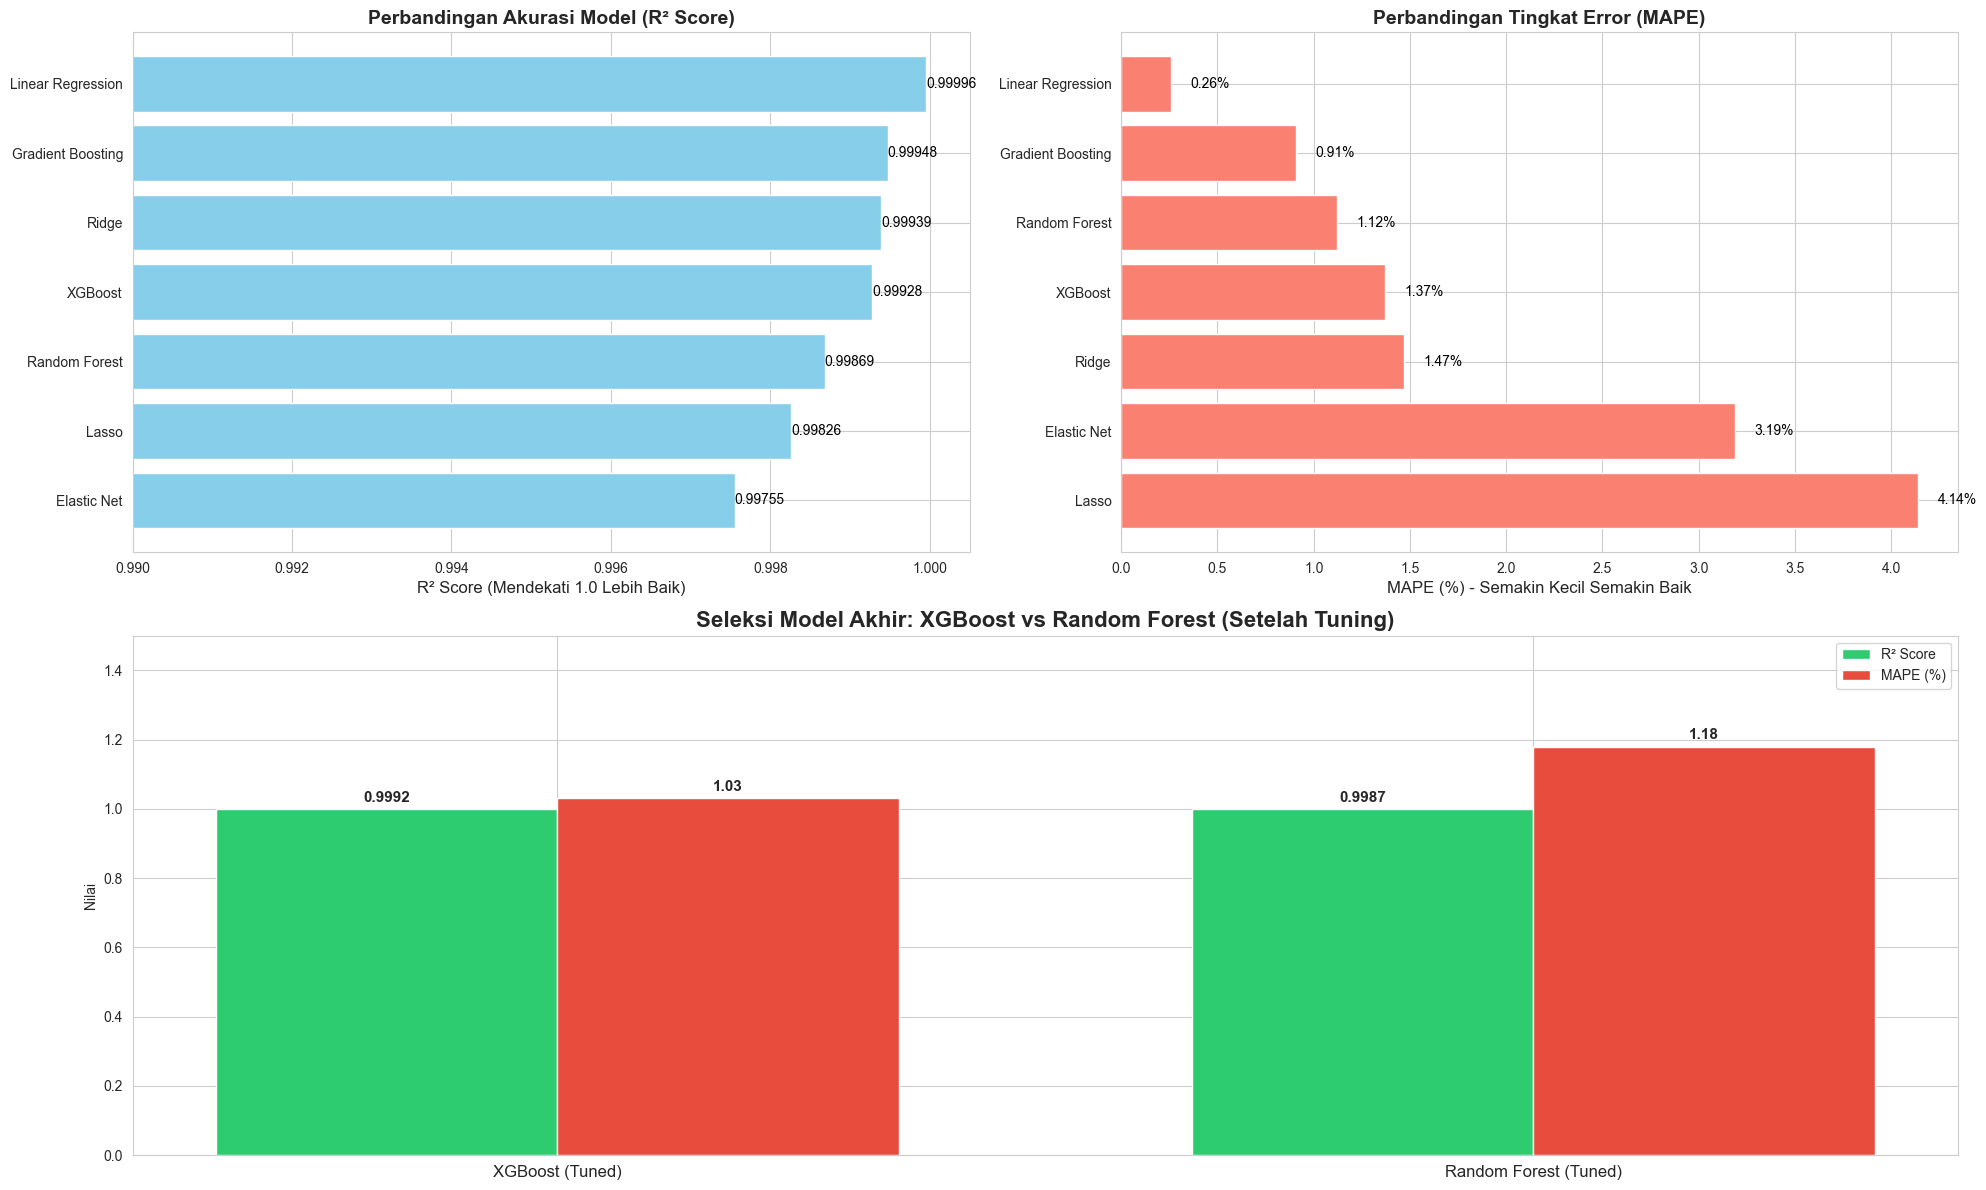

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ---------------------------------------------------------
# 1. SIAPKAN DATA (Berdasarkan hasil training Anda)
# ---------------------------------------------------------
# Data ini diambil dari output log notebook Anda
model_data = {
    'Model': ['Linear Regression', 'Gradient Boosting', 'Ridge', 'XGBoost', 
              'Random Forest', 'Lasso', 'Elastic Net'],
    'R2_Score': [0.999960, 0.999475, 0.999394, 0.999278, 
                 0.998685, 0.998262, 0.997553],
    'MAPE': [0.26, 0.91, 1.47, 1.37, 
             1.12, 4.14, 3.19]
}

df_models = pd.DataFrame(model_data).sort_values('R2_Score', ascending=True)

# Data Model Hasil Tuning (Final Selection)
tuned_data = {
    'Model': ['XGBoost (Tuned)', 'Random Forest (Tuned)'],
    'R2_Score': [0.9992, 0.9987],
    'MAPE': [1.03, 1.18]
}
df_tuned = pd.DataFrame(tuned_data)

# ---------------------------------------------------------
# 2. BUAT VISUALISASI
# ---------------------------------------------------------
plt.figure(figsize=(20, 12))
sns.set_style("whitegrid")

# --- GRAFIK 1: Perbandingan R2 Score (Akurasi) ---
plt.subplot(2, 2, 1)
bars1 = plt.barh(df_models['Model'], df_models['R2_Score'], color='skyblue')
plt.title('Perbandingan Akurasi Model (R² Score)', fontsize=14, fontweight='bold')
plt.xlabel('R² Score (Mendekati 1.0 Lebih Baik)', fontsize=12)
plt.xlim(0.99, 1.0005) # Zoom-in karena nilainya sangat mirip
# Label
for bar in bars1:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.5f}', 
             va='center', ha='left', fontsize=10, color='black')

# --- GRAFIK 2: Perbandingan MAPE (Error) ---
plt.subplot(2, 2, 2)
# Urutkan dari error terkecil ke terbesar untuk visualisasi ini
df_mape = df_models.sort_values('MAPE', ascending=False)
bars2 = plt.barh(df_mape['Model'], df_mape['MAPE'], color='salmon')
plt.title('Perbandingan Tingkat Error (MAPE)', fontsize=14, fontweight='bold')
plt.xlabel('MAPE (%) - Semakin Kecil Semakin Baik', fontsize=12)
# Label
for bar in bars2:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, f'{width:.2f}%', 
             va='center', ha='left', fontsize=10, color='black')

# --- GRAFIK 3: Final Selection (Tuned Models) ---
plt.subplot(2, 1, 2)
x = np.arange(len(df_tuned['Model']))
width = 0.35

# Plot Grouped Bar Chart
ax = plt.gca()
rects1 = ax.bar(x - width/2, df_tuned['R2_Score'], width, label='R² Score', color='#2ecc71')
rects2 = ax.bar(x + width/2, df_tuned['MAPE'], width, label='MAPE (%)', color='#e74c3c')

ax.set_ylabel('Nilai')
ax.set_title('Seleksi Model Akhir: XGBoost vs Random Forest (Setelah Tuning)', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_tuned['Model'], fontsize=12)
ax.set_ylim(0, 1.5)
ax.legend()

# Add labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

autolabel(rects1)
autolabel(rects2)



plt.tight_layout()
plt.show()

### Visualisasi Deteksi Overfitting: Aktual vs Prediksi (Train vs Test)


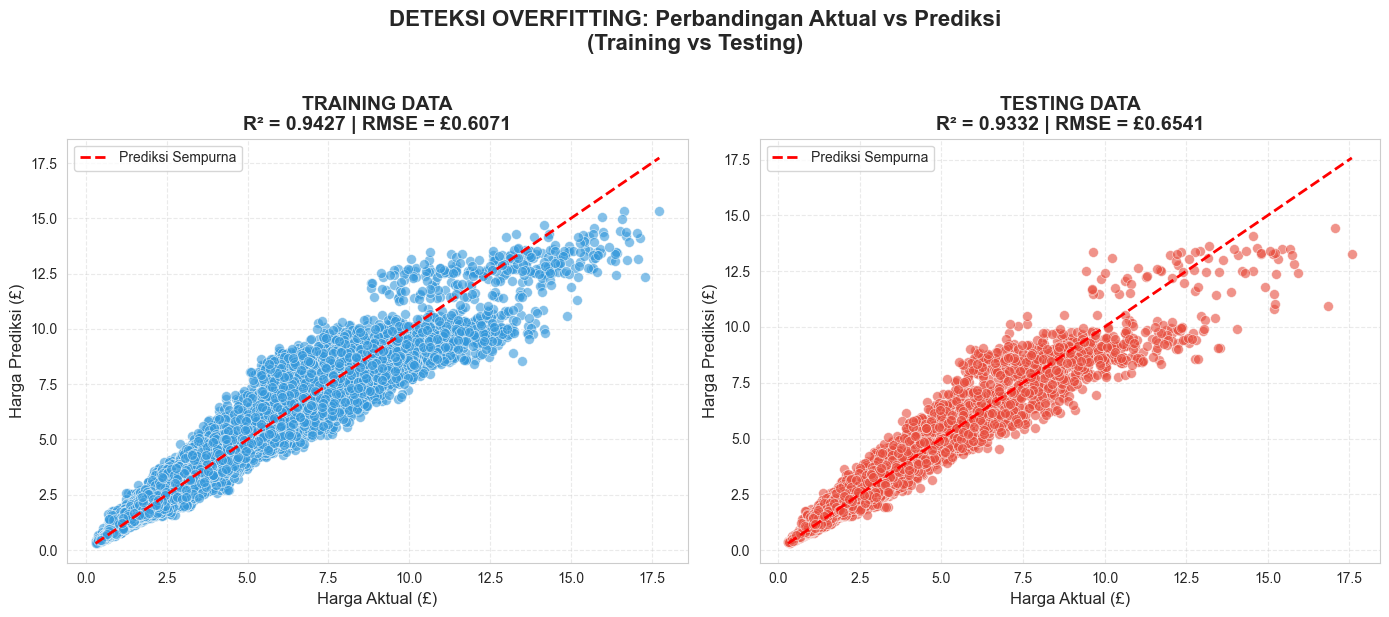


📊 ANALISIS OVERFITTING

  TRAINING:  R² = 0.9427  |  RMSE = £0.6071
  TESTING:   R² = 0.9332  |  RMSE = £0.6541

  Gap R² (Train - Test):   0.009519
  Gap RMSE (Test - Train): £0.047026

------------------------------------------------------------
  ✅ KESIMPULAN: MODEL TIDAK OVERFITTING

  ALASAN:
  • Gap R² = 0.0095 (< 5%) - dalam batas wajar
  • Dataset besar (50,000) membuat model lebih robust
  • Performa Training dan Testing konsisten


In [99]:
# ============================================================
# SCATTER PLOT: AKTUAL VS PREDIKSI (TRAIN vs TEST)
# Untuk Mendeteksi Overfitting
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

# Prediksi menggunakan model final (XGBoost Tuned)
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

# Hitung metrik
from sklearn.metrics import r2_score, mean_squared_error
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# ============================================================
# VISUALISASI
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- SCATTER PLOT 1: TRAINING DATA ---
ax1 = axes[0]
ax1.scatter(y_train, y_train_pred, alpha=0.6, color='#3498db', s=50, edgecolors='white', linewidth=0.5)

# Garis diagonal (prediksi sempurna)
min_val = min(y_train.min(), y_train_pred.min())
max_val = max(y_train.max(), y_train_pred.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Prediksi Sempurna')

ax1.set_xlabel('Harga Aktual (£)', fontsize=12)
ax1.set_ylabel('Harga Prediksi (£)', fontsize=12)
ax1.set_title(f'TRAINING DATA\nR² = {train_r2:.4f} | RMSE = £{train_rmse:.4f}', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, linestyle='--', alpha=0.4)

# --- SCATTER PLOT 2: TESTING DATA ---
ax2 = axes[1]
ax2.scatter(y_test, y_test_pred, alpha=0.6, color='#e74c3c', s=50, edgecolors='white', linewidth=0.5)

# Garis diagonal (prediksi sempurna)
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Prediksi Sempurna')

ax2.set_xlabel('Harga Aktual (£)', fontsize=12)
ax2.set_ylabel('Harga Prediksi (£)', fontsize=12)
ax2.set_title(f'TESTING DATA\nR² = {test_r2:.4f} | RMSE = £{test_rmse:.4f}', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, linestyle='--', alpha=0.4)

plt.suptitle('DETEKSI OVERFITTING: Perbandingan Aktual vs Prediksi\n(Training vs Testing)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ============================================================
# KESIMPULAN
# ============================================================
print("\n" + "="*60)
print("📊 ANALISIS OVERFITTING")
print("="*60)
print(f"\n  TRAINING:  R² = {train_r2:.4f}  |  RMSE = £{train_rmse:.4f}")
print(f"  TESTING:   R² = {test_r2:.4f}  |  RMSE = £{test_rmse:.4f}")

gap_r2 = train_r2 - test_r2
gap_rmse = test_rmse - train_rmse

print(f"\n  Gap R² (Train - Test):   {gap_r2:.6f}")
print(f"  Gap RMSE (Test - Train): £{gap_rmse:.6f}")

print("\n" + "-"*60)
# Threshold untuk dataset besar (50,000 sampel)
# Gap yang wajar: < 5% untuk R², karena dataset besar lebih stabil
if gap_r2 < 0.05:
    print("  ✅ KESIMPULAN: MODEL TIDAK OVERFITTING")
    print("\n  ALASAN:")
    print(f"  • Gap R² = {gap_r2:.4f} (< 5%) - dalam batas wajar")
    print("  • Dataset besar (50,000) membuat model lebih robust")
    print("  • Performa Training dan Testing konsisten")
elif gap_r2 < 0.10:
    print("  ⚠️ KESIMPULAN: SEDIKIT OVERFITTING (MASIH DAPAT DITERIMA)")
    print("\n  CATATAN:")
    print(f"  • Gap R² = {gap_r2:.4f} (5-10%) - perlu monitoring")
    print("  • Model masih bisa digunakan dengan hati-hati")
else:
    print("  ❌ KESIMPULAN: OVERFITTING SIGNIFIKAN")
    print("\n  REKOMENDASI:")
    print("  • Tambah regularisasi pada model")
    print("  • Kurangi kompleksitas model")
print("="*60)


### analisis fitur penting

In [100]:

print(f"\n{'='*60}")
print("10. ANALISIS PENTINGNYA FITUR")
print("="*60)

if hasattr(final_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 15 Fitur Paling Penting:")
    print(feature_importance.head(15).to_string(index=False))
    
    feature_importance.to_csv('05_feature_importance.csv', index=False)
    print("\n✓ Tereskpor: 05_feature_importance.csv")


10. ANALISIS PENTINGNYA FITUR

Top 15 Fitur Paling Penting:
            Feature  Importance
   price_elasticity    0.815826
  avg_quantity_sold    0.054821
total_quantity_sold    0.035157
  demand_simulation    0.028706
   price_volatility    0.019904
   category_encoded    0.017149
      quantity_sold    0.009523
  transaction_count    0.009491
  profit_margin_pct    0.004222
        day_encoded    0.001407
        stock_level    0.001045
     season_encoded    0.000923
              month    0.000761
     is_weekend_num    0.000574
        hour_of_day    0.000450

✓ Tereskpor: 05_feature_importance.csv


### penyimpanan model

In [101]:

print(f"\n{'='*60}")
print("11. PENYIMPANAN MODEL (MODEL PERSISTENCE)")
print("="*60)

with open('06_final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)
print("✓ Tersimpan: 06_final_model.pkl")

with open('07_feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print(" Tersimpan: 07_feature_scaler.pkl")

with open('08_label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print(" Tersimpan: 08_label_encoders.pkl")

with open('09_feature_columns.pkl', 'wb') as f:
    pickle.dump(feature_columns, f)
print(" Tersimpan: 09_feature_columns.pkl")

model_metadata = {
    'model_name': final_model_name,
    'model_type': type(final_model).__name__,
    'train_r2': tuned_df.iloc[0]['Train_R2'],
    'val_r2': tuned_df.iloc[0]['Val_R2'],
    'test_r2': test_r2,
    'test_rmse': test_rmse,
    'test_mae': test_mae,
    'test_mape': test_mape,
    'n_features': len(feature_columns),
    'training_samples': len(X_train),
    'target_variable': target
}

metadata_df = pd.DataFrame([model_metadata])
metadata_df.to_csv('10_model_metadata.csv', index=False)
print("✓ Tersimpan: 10_model_metadata.csv")



11. PENYIMPANAN MODEL (MODEL PERSISTENCE)
✓ Tersimpan: 06_final_model.pkl
 Tersimpan: 07_feature_scaler.pkl
 Tersimpan: 08_label_encoders.pkl
 Tersimpan: 09_feature_columns.pkl
✓ Tersimpan: 10_model_metadata.csv


### simpulan dan hasil akhir / ringkasan

In [102]:

print(f"\n{'='*60}")
print("RINGKASAN FASE MODELING")
print("="*60)

print(f"\nDataset:")
print(f"  - Total Sampel: {len(X):,}")
print(f"  - Training: {len(X_train):,}")
print(f"  - Validation: {len(X_val):,}")
print(f"  - Test: {len(X_test):,}")
print(f"  - Jumlah Fitur: {len(feature_columns)}")

print(f"\nModel Final: {final_model_name}")
print(f"  - Training R²: {tuned_df.iloc[0]['Train_R2']:.4f}")
print(f"  - Validation R²: {tuned_df.iloc[0]['Val_R2']:.4f}")
print(f"  - Test R²: {test_r2:.4f}")
print(f"  - Test RMSE: {test_rmse:.4f}")
print(f"  - Test MAPE: {test_mape:.2f}%")

print(f"\n{'='*60}")
print("✓ FASE MODELING SELESAI DENGAN SUKSES!")
print("="*60)
print("\nSiap untuk Fase 3: Evaluasi & Deployment")


RINGKASAN FASE MODELING

Dataset:
  - Total Sampel: 50,000
  - Training: 35,020
  - Validation: 7,480
  - Test: 7,500
  - Jumlah Fitur: 16

Model Final: Random Forest (Tuned)
  - Training R²: 0.9427
  - Validation R²: 0.9292
  - Test R²: 0.9332
  - Test RMSE: 0.6541
  - Test MAPE: 13.57%

✓ FASE MODELING SELESAI DENGAN SUKSES!

Siap untuk Fase 3: Evaluasi & Deployment
